In [1]:
import pandas as pd
import io
import requests
import deepcut

Using TensorFlow backend.


In [17]:
df = pd.read_csv('facebook_20180805.csv')
df.head()

,id,date,category,label,text
0,236308269755499_516631321723191,2/12/2013 15:26,สุขภาพ,1,สวัสดีครับเพื่อนๆ..เมื่อวานนี้ผมได้ไปช่วยครอบค...
1,236308269755499_516637568389233,2/12/2013 15:52,สุขภาพ,1,นี่คือภาพคุณ นคร ตอนถูกชนเมื่อปีที่แล้ว เมื่อว...
2,236308269755499_518039984915658,2/15/2013 19:29,ความเป็นอยู่,2,สวัสดีครับเพื่อนๆ..วันนี้ผมมาหาอาจารย์ท่านหนึ่...
3,236308269755499_519530701433253,2/18/2013 13:46,การเข้าถึงบริการภาครัฐ,3,สวัสดีครับเพื่อนๆ..เมื่อวานนี้ได้เข้าไปช่วยเหล...
4,236308269755499_520560281330295,2/20/2013 17:55,สุขภาพ,1,สวัสดีครับเพื่อนๆ..เมื่อวานนี้ผมได้ไปหาน้องอุ้...


In [18]:
from io import StringIO

col = ['category', 'label', 'text']
df = df[col]
df = df[pd.notnull(df['text'])]
df['category_id'] = df['category']

category_id_df = df[['category', 'label']].drop_duplicates().sort_values('label')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['label', 'category']].values)

df.head()

,category,label,text,category_id
0,สุขภาพ,1,สวัสดีครับเพื่อนๆ..เมื่อวานนี้ผมได้ไปช่วยครอบค...,สุขภาพ
1,สุขภาพ,1,นี่คือภาพคุณ นคร ตอนถูกชนเมื่อปีที่แล้ว เมื่อว...,สุขภาพ
2,ความเป็นอยู่,2,สวัสดีครับเพื่อนๆ..วันนี้ผมมาหาอาจารย์ท่านหนึ่...,ความเป็นอยู่
3,การเข้าถึงบริการภาครัฐ,3,สวัสดีครับเพื่อนๆ..เมื่อวานนี้ได้เข้าไปช่วยเหล...,การเข้าถึงบริการภาครัฐ
4,สุขภาพ,1,สวัสดีครับเพื่อนๆ..เมื่อวานนี้ผมได้ไปหาน้องอุ้...,สุขภาพ


In [19]:
df['text'] = [" ".join(deepcut.tokenize(l)) for l in df.text]
df.head()

,category,label,text,category_id
0,สุขภาพ,1,สวัสดี ครับ เพื่อน ๆ .. เมื่อ วาน นี้ ผม ได้ ไ...,สุขภาพ
1,สุขภาพ,1,นี่ คือ ภาพ คุณ นคร ตอน ถูก ชน เมื่อ ปี ที...,สุขภาพ
2,ความเป็นอยู่,2,สวัสดี ครับ เพื่อน ๆ.. วัน นี้ ผม มา หา อาจารย...,ความเป็นอยู่
3,การเข้าถึงบริการภาครัฐ,3,สวัสดี ครับ เพื่อน ๆ .. เมื่อ วาน นี้ ได้ เข้า...,การเข้าถึงบริการภาครัฐ
4,สุขภาพ,1,สวัสดี ครับ เพื่อน ๆ .. เมื่อ วาน นี้ ผม ได้ ไ...,สุขภาพ


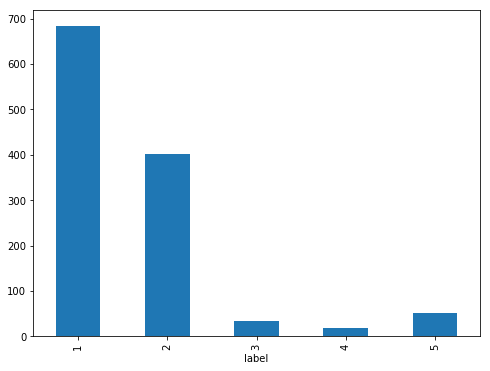

In [20]:
# 1: สุขภาพ
# 2: ความเป็นอยู่
# 3: การเข้าถึงบริการภาครัฐ
# 4: การศึกษา
# 5: เศรษฐกิจ

import matplotlib.pyplot as plt
import matplotlib as mpl
fp = mpl.font_manager.FontProperties(family='arial',size=20)

fig = plt.figure(figsize=(8,6))
df.groupby('label').text.count().plot.bar(ylim=0)
plt.show()

In [48]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(analyzer="word", sublinear_tf=True, norm='l2', encoding='utf-8', ngram_range=(1, 5))
#features = tfidf.fit_transform(df.Consumer_complaint_narrative).toarray()

features = tfidf.fit_transform(df.text).toarray()

labels = df.category_id

features.shape

(1190, 494493)

In [49]:
from sklearn.feature_selection import chi2

import numpy as np
N = 2
for Product, category_id in sorted(category_to_id.items()):
  features_chi2 = chi2(features, labels == category_id)
  indices = np.argsort(features_chi2[0])
  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
  print("# '{}':".format(Product))
  print("  . Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-N:])))
  print("  . Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-N:])))

# 'การศึกษา':
  . Most correlated unigrams:
. ผมาม
. ผมกด
  . Most correlated bigrams:
. ผล ดผ
. ผล จาก
# 'การเข้าถึงบริการภาครัฐ':
  . Most correlated unigrams:
. ผมาม
. ผมกด
  . Most correlated bigrams:
. ผล ดผ
. ผล จาก
# 'ความเป็นอยู่':
  . Most correlated unigrams:
. ผมาม
. ผมกด
  . Most correlated bigrams:
. ผล ดผ
. ผล จาก
# 'สุขภาพ':
  . Most correlated unigrams:
. ผมาม
. ผมกด
  . Most correlated bigrams:
. ผล ดผ
. ผล จาก
# 'เศรษฐกิจ':
  . Most correlated unigrams:
. ผมาม
. ผมกด
  . Most correlated bigrams:
. ผล ดผ
. ผล จาก


In [40]:
features[0]

array([ 0.,  0.,  0., ...,  0.,  0.,  0.])

In [38]:
from sklearn.feature_selection import chi2

import numpy as np
N = 2
for Product, category_id in sorted(category_to_id.items()):
  features_chi2 = chi2(features, labels == category_id)
  indices = np.argsort(features_chi2[0])
  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
  #print("# '{}':".format(Product))
  #print("  . Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-N:])))
  #print("  . Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-N:])))
    
  print(feature_names)

['00' 'อด ตอน' 'อด ตา' ..., 'ธยา เด' 'ธยา เม' 'ไใ เห']
['00' 'อด ตอน' 'อด ตา' ..., 'ธยา เด' 'ธยา เม' 'ไใ เห']
['00' 'อด ตอน' 'อด ตา' ..., 'ธยา เด' 'ธยา เม' 'ไใ เห']
['00' 'อด ตอน' 'อด ตา' ..., 'ธยา เด' 'ธยา เม' 'ไใ เห']
['00' 'อด ตอน' 'อด ตา' ..., 'ธยา เด' 'ธยา เม' 'ไใ เห']


In [27]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

X_train, X_test, y_train, y_test = train_test_split(df['text'], df['category'], random_state = 0)
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
clf = MultinomialNB().fit(X_train_tfidf, y_train)

In [34]:
print(clf.predict(count_vect.transform(["สวัสดีครับเพื่อนๆ..เมื่อวานนี้ผมได้ไปช่วยครอบครัวของคุณ นคร เทียนขำ ซึ่งถูกรถชนแล้วหลบหนีขณะกำลังจะกลับบ้าน คุณ นคร ทำงานที่สำนักเขต คลองเตย ตำแหน่ง เก็บขยะ คุณแม่ก็ทำงานที่เดียวกัน คุณแม่มีหน้าที่กวาดขยะ ตอนนี้คุณแม่ทำงานคนเดียว เพราะคุณ นคร ได้เสียความทรงจำ สมองสั่งงานช้า อึ ฉี่ โดยไม่รู้ตัว ต้องใส่แพมเพิตตลอดเวลาเหตุเกิดเมื่อปีที่แล้ว คุณ นคร ต้องผ่ากระโหลก และนอน รพ เดือนครึ่ง ตอน2เดือนที่แล้วคุณหมอให้ไปใส่กระโหลกเทียม แต่คุณแม่ไม่มีเงินก็เลยยังไม่ได้ใส่ เพราะค่าใช้จ่ายทั้งหมด30,000บาท คุณแม่ก็เลยขอผลัดไปก่อน คุณพ่อเสียไป15ปีที่แล้ว แม่ต้องหาเลี้ยงลูกคนเดียวเงินเดือน12,000บาทหักใช้หนี้สหกรณ์6,000บาทเหลือ6,000บาทเมื่อวานผมให้คุณแม่นัดหมอเพื่อทำการใส่กระโหลกเทียมให้น้องแล้วครับ โดยจะออกค่าใช้จ่ายให้คุณ นคร ทั้งหมด ตอนนี้ คุณ นคร อายุ 30ปี คุณแม่ 50ปี ก็ควต้องดูแลกันและกันไปอีกนานครับ ถ้าเพื่อนๆท่านใดอยากจะช่วยเหลือคุณ นคร ก็ยินดีครับชื่อ บ/ช นาง สมควร พุ่มสงวน ธ.กรุงไทย สาขาเอกมัย  เลขที่ บ/ช 053-0099578 ออมทรัพย์อยู่บ้านเลขที่ 8/270 ซ.อาจณรงค์1 ข.คลองเตยเขต คลองเตย ขอบคุณมากๆครับ"])))

['สุขภาพ']


In [35]:
df[df['text'] == "สวัสดีครับเพื่อนๆ..เมื่อวานนี้ผมได้ไปช่วยครอบครัวของคุณ นคร เทียนขำ ซึ่งถูกรถชนแล้วหลบหนีขณะกำลังจะกลับบ้าน คุณ นคร ทำงานที่สำนักเขต คลองเตย ตำแหน่ง เก็บขยะ คุณแม่ก็ทำงานที่เดียวกัน คุณแม่มีหน้าที่กวาดขยะ ตอนนี้คุณแม่ทำงานคนเดียว เพราะคุณ นคร ได้เสียความทรงจำ สมองสั่งงานช้า อึ ฉี่ โดยไม่รู้ตัว ต้องใส่แพมเพิตตลอดเวลาเหตุเกิดเมื่อปีที่แล้ว คุณ นคร ต้องผ่ากระโหลก และนอน รพ เดือนครึ่ง ตอน2เดือนที่แล้วคุณหมอให้ไปใส่กระโหลกเทียม แต่คุณแม่ไม่มีเงินก็เลยยังไม่ได้ใส่ เพราะค่าใช้จ่ายทั้งหมด30,000บาท คุณแม่ก็เลยขอผลัดไปก่อน คุณพ่อเสียไป15ปีที่แล้ว แม่ต้องหาเลี้ยงลูกคนเดียวเงินเดือน12,000บาทหักใช้หนี้สหกรณ์6,000บาทเหลือ6,000บาทเมื่อวานผมให้คุณแม่นัดหมอเพื่อทำการใส่กระโหลกเทียมให้น้องแล้วครับ โดยจะออกค่าใช้จ่ายให้คุณ นคร ทั้งหมด ตอนนี้ คุณ นคร อายุ 30ปี คุณแม่ 50ปี ก็ควต้องดูแลกันและกันไปอีกนานครับ ถ้าเพื่อนๆท่านใดอยากจะช่วยเหลือคุณ นคร ก็ยินดีครับชื่อ บ/ช นาง สมควร พุ่มสงวน ธ.กรุงไทย สาขาเอกมัย  เลขที่ บ/ช 053-0099578 ออมทรัพย์อยู่บ้านเลขที่ 8/270 ซ.อาจณรงค์1 ข.คลองเตยเขต คลองเตย ขอบคุณมากๆครับ"]

,category,label,text,category_id


In [36]:
print(clf.predict(count_vect.transform(["สวัสดีครับเพื่อนๆ..เมื่อวานนี้ผมได้ไปช่วยครอบครัวของคุณ นคร เทียนขำ ซึ่งถูกรถชนแล้วหลบหนีขณะกำลังจะกลับบ้าน คุณ นคร ทำงานที่สำนักเขต คลองเตย ตำแหน่ง เก็บขยะ คุณแม่ก็ทำงานที่เดียวกัน คุณแม่มีหน้าที่กวาดขยะ ตอนนี้คุณแม่ทำงานคนเดียว เพราะคุณ นคร ได้เสียความทรงจำ สมองสั่งงานช้า อึ ฉี่ โดยไม่รู้ตัว ต้องใส่แพมเพิตตลอดเวลาเหตุเกิดเมื่อปีที่แล้ว คุณ นคร ต้องผ่ากระโหลก และนอน รพ เดือนครึ่ง ตอน2เดือนที่แล้วคุณหมอให้ไปใส่กระโหลกเทียม แต่คุณแม่ไม่มีเงินก็เลยยังไม่ได้ใส่ เพราะค่าใช้จ่ายทั้งหมด30,000บาท คุณแม่ก็เลยขอผลัดไปก่อน คุณพ่อเสียไป15ปีที่แล้ว แม่ต้องหาเลี้ยงลูกคนเดียวเงินเดือน12,000บาทหักใช้หนี้สหกรณ์6,000บาทเหลือ6,000บาทเมื่อวานผมให้คุณแม่นัดหมอเพื่อทำการใส่กระโหลกเทียมให้น้องแล้วครับ โดยจะออกค่าใช้จ่ายให้คุณ นคร ทั้งหมด ตอนนี้ คุณ นคร อายุ 30ปี คุณแม่ 50ปี ก็ควต้องดูแลกันและกันไปอีกนานครับ ถ้าเพื่อนๆท่านใดอยากจะช่วยเหลือคุณ นคร ก็ยินดีครับชื่อ บ/ช นาง สมควร พุ่มสงวน ธ.กรุงไทย สาขาเอกมัย  เลขที่ บ/ช 053-0099578 ออมทรัพย์อยู่บ้านเลขที่ 8/270 ซ.อาจณรงค์1 ข.คลองเตยเขต คลองเตย ขอบคุณมากๆครับ"])))

['สุขภาพ']


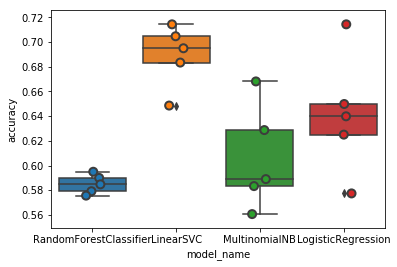

In [32]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score

models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

import seaborn as sns
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

In [ ]:
cv_df.groupby('model_name').accuracy.mean()

In [ ]:
model = LinearSVC()
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, df.index, test_size=0.33, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df.Product.values, yticklabels=category_id_df.Product.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [ ]:
from IPython.display import display
for predicted in category_id_df.category_id:
  for actual in category_id_df.category_id:
    if predicted != actual and conf_mat[actual, predicted] >= 10:
      print("'{}' predicted as '{}' : {} examples.".format(id_to_category[actual], id_to_category[predicted], conf_mat[actual, predicted]))
      display(df.loc[indices_test[(y_test == actual) & (y_pred == predicted)]][['Product', 'Consumer_complaint_narrative']])
      print('')

In [ ]:
model.fit(features, labels)
N = 2
for Product, category_id in sorted(category_to_id.items()):
  indices = np.argsort(model.coef_[category_id])
  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 1][:N]
  bigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 2][:N]
  print("# '{}':".format(Product))
  print("  . Top unigrams:\n       . {}".format('\n       . '.join(unigrams)))
  print("  . Top bigrams:\n       . {}".format('\n       . '.join(bigrams)))

In [ ]:
from sklearn import metrics
print(metrics.classification_report(y_test, y_pred, target_names=df['Product'].unique()))